<a href="https://colab.research.google.com/github/shnapera/shnapera/blob/main/predict_android_class4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**26** April 2023

In [ ]:
# Used
# https://www.kaggle.com/code/akhatova/sms-spam-classification-by-keras
#       ALFIIA AKHATOVA
# https://www.kaggle.com/code/ngawangchoeda/spam-classifier-using-lstm
#       NGAWANG CHOEDA
# https://www.thepythoncode.com/article/build-spam-classifier-keras-python
#       Abdou Rockikz
# As a starting point

In [ ]:
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from bs4 import BeautifulSoup

from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import (
    classification_report, accuracy_score, confusion_matrix)


import keras
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
def show_roc_curve(model,X,y,title):
    
  y_pred_keras = model.predict(X,verbose=False).ravel()
  fpr_keras, tpr_keras, thresholds_keras = roc_curve(y, y_pred_keras)
  auc_keras = auc(fpr_keras, tpr_keras)

  plt.figure(1)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title(f'ROC curve ({title})')
  plt.legend(loc='best')
  plt.show()

In [ ]:
def print_metrics(
    title,
    model,
    X_train, y_train,
    X_validation, y_validation
    ):
  
  print(title)

  loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
  print("Training Accuracy: {:.4f}".format(accuracy))
  loss, accuracy = model.evaluate(X_validation, y_validation, verbose=False)
  print("Validation Accuracy:  {:.4f}".format(accuracy))
  y_pred = (model.predict(X_validation,verbose=False) >= 0.5).astype(int)
  print('f1_score on validation',f1_score(y_validation,y_pred))
  print()
  plot_history(history)


In [ ]:
def print_cm(model,X,y):
  ypred = model.predict(X, verbose=False)
  ypred = ypred>0.5
  #Get the confusion matrix
  cf_matrix = confusion_matrix(y, ypred)
  fig, ax = plt.subplots(figsize=(5,4))
  sns.heatmap(
      cf_matrix,annot = True,
      fmt =',d',
      cmap='viridis',
      ax=ax)
  plt.xlabel('Predicted label')
  plt.ylabel('True label')
  plt.show()

In [ ]:
# Parameters
SEQUENCE_LENGTH = 300 # the length of all sequences (number of words per sample)
# EMBEDDING_SIZE = 300 # Using 300-Dimensional embedding vectors
EMBEDDING_SIZE = 200  # Using 200-Dimensional embedding vectors
VALIDATION_SIZE = 0.20 # ratio of validation set

In [ ]:
# Input dataset - AFTER Uploading CSV to Colab file-system Directory: /content



all_train_df = pd.read_csv('/content/Android_train.csv',encoding="ISO-8859-1") # Train + validation set
test_df = pd.read_csv('/content/Android_test.csv',encoding="ISO-8859-1")

In [ ]:
# Note test_df doesnt contain y. So we use validation set to measure models accuracy
test_df['predicted_y'].isna().sum()

5000

In [ ]:
all_train_df.head(1)

,App,Package,Category,Description,Rating,Number of ratings,Price,Related apps,Dangerous permissions count,Safe permissions count,...,Your personal information : read calendar events (D),Your personal information : read contact data (D),Your personal information : read sensitive log data (D),Your personal information : read user defined dictionary (D),Your personal information : retrieve system internal state (S),Your personal information : set alarm in alarm clock (S),Your personal information : write Browser's history and bookmarks (D),Your personal information : write contact data (D),Your personal information : write to user defined dictionary (S),Class
0,Canada Post Corporation,com.canadapost.android,Business,Canada Post Mobile App gives you access to som...,3.1,77,0.0,"{com.adaffix.pub.ca.android, com.kevinquan.gas...",7.0,1,...,0,1,0,0,0,0,0,1,0,0


In [ ]:
print(all_train_df.Package.apply(lambda s: s.split('.')[0]).value_counts())

com       18274
net         614
jp          557
org         529
air         320
          ...  
fxware        1
pec           1
sz            1
S             1
toaset        1
Name: Package, Length: 1294, dtype: int64


In [ ]:
# Feature engineering

# NOTE: Strictly speaking - When doing an embedding of text - 
#           Catigorical fields are concatenated to the RESULT of the embedding - not to the raw text. 
#   However - In our case it is also possible to improve F1 by concatenating them to raw text

all_train_df['Description'] = all_train_df['Description'].fillna('').astype(str)
test_df['Description'] = test_df['Description'].fillna('').astype(str)

#print(all_train_df.Package.apply(lambda s: s.split('.')[0]).value_counts())
all_train_df['Package_main'] = all_train_df.Package.apply(lambda s: s.split('.')[0])
test_df['Package_main'] = test_df.Package.apply(lambda s: s.split('.')[0])

# # dgc = Dangerous permissions count
# low_dgc = all_train_df['Dangerous permissions count'].quantile(q=0.2)
# high_dgc = all_train_df['Dangerous permissions count'].quantile(q=0.8)
# print('low_dgc,high_dgc:',low_dgc,high_dgc)

# all_train_df['dgc'] = np.where(all_train_df['Dangerous permissions count'] < low_dgc, 'dgclow','dgcmedium')
# all_train_df['dgc'] = np.where(all_train_df['Dangerous permissions count'] > high_dgc, 'dgchigh',all_train_df['dgc'])

# test_df['dgc'] = np.where(test_df['Dangerous permissions count'] < low_dgc, 'dgclow','dgcmedium')
# test_df['dgc'] = np.where(test_df['Dangerous permissions count'] > high_dgc, 'dgchigh',test_df['dgc'])
# all_train_df['dgc'].value_counts()

all_train_df['text'] = all_train_df.apply(
    #lambda row: row['Package_main'] + ' ' + row['dgc'] + ' ' +row['Category'] + ' ' + row['Description']
    lambda row: row['Package_main'] + ' ' + row['Category'] + ' ' + row['App'] + ' ' + row['Description']
    , axis=1)

test_df['text'] = test_df.apply(
     lambda row: row['Package_main'] + ' ' + row['Category'] + ' ' + row['App'] + ' ' + row['Description']
    , axis=1)

In [ ]:
tst_text = all_train_df.iloc[0]['text']
tst_text

'com Business Canada Post Corporation Canada Post Mobile App gives you access to some of the the most popular tools on <a href="http://www.google.com/url?q=http://canadapost.ca&usg=AFQjCNGLsUtAzxPlFZBfYYGjv6mnRiMZJw" target="_blank">canadapost.ca</a>.  You can now Find a Postal Code, create your own personalized stamps and postcards with Picture Postage, Track a Package and Find a Post Office anywhere in Canada.<p>Now introducing Picture Postage Postcard!<p>Turn your photos into printed postcards???with delivery anywhere in the world for just $2.45 per card! Take a photo or select one from your camera roll, choose the recipient(s) from your contacts list and write your personal message. We???ll print, stamp and mail the postcard to each person on your list!<p>Use Picture Postage to create a personalized stamp for your letters and invitations.  Get started by taking a picture with your device, or access any photos that you have stored on your camera roll!<p>Use Find a Postal code for an

In [ ]:
stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    

    soup = BeautifulSoup(text, "html.parser") #Remove html tags
    text = soup.get_text()    

    text = re.sub(r'[,()!]',' ',text, re.UNICODE)
    text = re.sub(r'[\?\.]','',text, re.UNICODE)    
    text = re.sub(r'[^\w\s]','',text, re.UNICODE)
    text = re.sub(r'\d+','',text, re.UNICODE) # Remove numbers

    text = text.lower()
    text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
    text = [lemmatizer.lemmatize(token, "v") for token in text]
    text = [word for word in text if not word in stop_words]
    text = " ".join(text)
    return text

In [ ]:
clean_text(tst_text)

'com business canada post corporation canada post mobile app give access popular tool canadapostca  find postal code  create personalize stamp postcard picture postage  track package find post office anywhere canadanow introduce picture postage postcard turn photo print postcardswith delivery anywhere world  per card  take photo select one camera roll  choose recipient  contact list write personal message well print  stamp mail postcard person list use picture postage create personalize stamp letter invitation  get start take picture device  access photo store camera roll use find postal code address canadause track package track check status item  give item name save app  eg  mom package   easily keep track delivereduse find post office locate nearest canada post retail outlet  base gps coordinate address enter'

In [ ]:
all_train_df['text'] = all_train_df.text.apply(lambda x: clean_text(x))
test_df['text'] = test_df.text.apply(lambda x: clean_text(x))

<ipython-input-16-fcff709d48fa>:7: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser") #Remove html tags


In [ ]:
#  train-validation split

 # Shuffle before train-validation split
all_train_df = shuffle(all_train_df,random_state=17).reset_index(drop=True)

train_set_size = int(len(all_train_df) * (1-VALIDATION_SIZE))
train_df = all_train_df[:train_set_size]
validation_df = all_train_df[train_set_size:]

print('all_train_df.shape',all_train_df.shape)
print('train_df.shape',train_df.shape)
print('validation_df.shape',validation_df.shape)
print('test_df.shape',test_df.shape)

# all_train_df.shape (25000, 184)
# train_df.shape (20000, 184)
# validation_df.shape (5000, 184)
# test_df.shape (5000, 184)

all_train_df.shape (25000, 186)
train_df.shape (20000, 186)
validation_df.shape (5000, 186)
test_df.shape (5000, 186)


In [ ]:
 # Clean dataset by removing punctuations, lowercase all characters, etc. 
 # Keras has a built-in class Tokenizer from the tensorflow.keras.preprocessing.text module, that does all that in few lines of code

# Text tokenization
# vectorizing text, turning each text into sequence of integers
#tokenizer = Tokenizer(num_words=5000)
#tokenizer = Tokenizer() # 26.4.2023

NUM_WORDS = 30000
tokenizer = Tokenizer(num_words=NUM_WORDS)
tokenizer.fit_on_texts(train_df['text'])

# The word_index contains all the words, no matter you set num_words or not.
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
print('vocab_size:',vocab_size)
# vocab_size : 134,567 Without numbers: 129,147
vocab_size = min(NUM_WORDS+1,vocab_size) # Needed for models embedding layer input shape

# convert to sequence of integers
X_train = tokenizer.texts_to_sequences(train_df['text'])
X_validation = tokenizer.texts_to_sequences(validation_df['text'])
X_test = tokenizer.texts_to_sequences(test_df['text'])

y_train = train_df['Class'].values
y_validation = validation_df['Class'].values



# Tokenizer returns sequence of integers, each integer corresponds to a word in the vocabulary.
# The samples don't have the same length, The NN needs a fixed-length sequence.
# Use pad_sequences() function from the tensorflow.keras.preprocessing.sequence module to pad sequences at the end of each sequence with zeros

# convert to numpy arrays
X_train = np.array(X_train)
X_train = pad_sequences(X_train, maxlen=SEQUENCE_LENGTH, padding='post')
X_validation = np.array(X_validation)
X_validation = pad_sequences(X_validation, maxlen=SEQUENCE_LENGTH, padding='post')
X_test = np.array(X_test)
X_test = pad_sequences(X_test, maxlen=SEQUENCE_LENGTH, padding='post') # Used to create predicted_y

vocab_size: 133161


<ipython-input-20-ebcfc6223236>:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_train = np.array(X_train)
<ipython-input-20-ebcfc6223236>:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_validation = np.array(X_validation)
<ipython-input-20-ebcfc6223236>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_test = np.array(X_te

In [ ]:
train_df.iloc[0].text

'com medium  video audiomanager pro fully feature version popular audiomanager widget volume managerfeatured best android apps book oreilly best audio management app androidaudiomanager applicationwidget allow get current volume level straight homescreen tap widget adjust volume level independently save audio set presets use builtin scheduler automatically apply youfeatures  widget skin available android market two widget size available  large x small x  save audio profile  presets  rename  edit delete profile  presets  create profile shortcut builtin scheduler automatically apply presets whenever want restore ringer mode feature fully optimize android tablet available  different language create publish skin skin development kit audiomanager plugin available locale tasker user auto backup restore lose set profile  support device  manual backup restore profile also availablewe appreciate feedback encourage help u improve product visit website httpwww.smartandroidapps.com forget check ap

In [ ]:
X_train[0]

array([    3,   253,    36, 13501,   116,   608,    12,    24,   325,
       13501,    75,   678,    28,     4,    53,    45,  8717,    28,
         167,   666,     1,   129,     9,   287,   678,    73,  1440,
        2215,   126,    75,  1343,   678,    73,  4050,    61,   167,
          29,  3288,     5,  1637,  6454,   304,   595, 12520,    75,
        1397,    52,     4,    91,   218,    75,   292,    52,   934,
         171,   605,   171,    61,   167,   833,  3288,  2900,   629,
         712,   833,  3288,   119,   833,  1113,  1637,  6454,   304,
         595,  3288,  1554,    58,  1106,  1952,    74,    12,   608,
         809,     4,   254,    52,    87,   102,   119,  1281,  1397,
        1397,   774,  2901, 13501,  1609,    52,  3475,  4895,    66,
         456,   632,  1106,   497,    29,   833,    21,    41,  1157,
         632,  1106,   833,    33, 17658,  1572,   327,  2072,    34,
          30,   290,   392,   262,   341,     3,   885,    90,    53,
          91,   468,

In [ ]:
#train_df.columns
#test_df.columns
print('Class is our target, Check if imbalanced\n')
print('train_df:',train_df['Class'].value_counts(),sep='\n')
print()
print('validation_df:',validation_df['Class'].value_counts(),sep='\n')

# Class is our target, Check if imbalanced

# train_df:
# 1    13354
# 0     6646
# Name: Class, dtype: int64

# validation_df:
# 1    3339
# 0    1661
# Name: Class, dtype: int64

Class is our target, Check if imbalanced

train_df:
1    13354
0     6646
Name: Class, dtype: int64

validation_df:
1    3339
0    1661
Name: Class, dtype: int64


In [ ]:
# Compute class weights
class_weights = compute_class_weight(y=y_train,class_weight='balanced',classes=np.unique(y_train))
class_weights = dict(zip(np.unique(y_train), class_weights))
class_weights

{0: 1.5046644598254588, 1: 0.7488392990864161}

In [ ]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

Build the model
The 1st model only contains a dense layer
The layers are stacked sequentially to build the classifier:

The first layer is an Embedding layer. This layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: (batch, sequence, embedding).
Next, a GlobalAveragePooling1D layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
This fixed-length output vector is piped through a fully-connected (Dense) layer with 16 hidden units.
The last layer is densely connected with a single output node. Using the sigmoid activation function, this value is a float between 0 and 1, representing a probability, or confidence level.

In [ ]:
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, EMBEDDING_SIZE))
model.add(keras.layers.GlobalMaxPool1D())
model.add(keras.layers.Dense(64, activation=tf.nn.relu))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(16, activation=tf.nn.relu))
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

LEARNING_RATE = 0.0001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 200)         6000200   
                                                                 
 global_max_pooling1d (Globa  (None, 200)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 64)                12864     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                1040      
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                        

In [ ]:
model.get_compile_config()

{'optimizer': {'module': 'keras.optimizers',
  'class_name': 'Adam',
  'config': {'name': 'Adam',
   'weight_decay': None,
   'clipnorm': None,
   'global_clipnorm': None,
   'clipvalue': None,
   'use_ema': False,
   'ema_momentum': 0.99,
   'ema_overwrite_frequency': None,
   'jit_compile': True,
   'is_legacy_optimizer': False,
   'learning_rate': 9.999999747378752e-05,
   'beta_1': 0.9,
   'beta_2': 0.999,
   'epsilon': 1e-07,
   'amsgrad': False},
  'registered_name': None},
 'loss': 'binary_crossentropy',
 'metrics': ['accuracy'],
 'loss_weights': None,
 'weighted_metrics': None,
 'run_eagerly': None,
 'steps_per_execution': None,
 'jit_compile': None}

In [ ]:
'''
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 embedding_4 (Embedding)     (None, None, 200)         6000200   
                                                                 
 global_max_pooling1d_3 (Glo  (None, 200)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_11 (Dense)            (None, 64)                12864     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 16)                1040      
                                                                 
 dense_13 (Dense)            (None, 1)                 17        
                                                                 
=================================================================
Total params: 6,014,121
Trainable params: 6,014,121
Non-trainable params: 0
_________________________________________________________________
''';

In [ ]:
BATCH_SIZE = 64
EPOCHS = 25 # number of epochs

mcp_save = ModelCheckpoint(
    'dense_best', save_best_only=True, monitor='val_accuracy', mode='max',
    #verbose=1
    )

history = model.fit(X_train, y_train,
                    epochs=EPOCHS,
                    verbose=True,
                    validation_data=(X_validation, y_validation),
                    batch_size=BATCH_SIZE,
                    callbacks=[mcp_save],
                    class_weight=class_weights
                    )

Epoch 1/25
313/313 [==============================] - 80s 234ms/step - loss: 0.6878 - accuracy: 0.6482 - val_loss: 0.6690 - val_accuracy: 0.7544
Epoch 2/25
313/313 [==============================] - 47s 152ms/step - loss: 0.6467 - accuracy: 0.7578 - val_loss: 0.5977 - val_accuracy: 0.7742
Epoch 3/25
313/313 [==============================] - 33s 106ms/step - loss: 0.5385 - accuracy: 0.7878 - val_loss: 0.4953 - val_accuracy: 0.7818
Epoch 4/25
313/313 [==============================] - 26s 84ms/step - loss: 0.4370 - accuracy: 0.8133 - val_loss: 0.4262 - val_accuracy: 0.8106
Epoch 5/25
313/313 [==============================] - 20s 65ms/step - loss: 0.3743 - accuracy: 0.8378 - val_loss: 0.4012 - val_accuracy: 0.8156
Epoch 6/25
313/313 [==============================] - 20s 63ms/step - loss: 0.3318 - accuracy: 0.8559 - val_loss: 0.3877 - val_accuracy: 0.8228
Epoch 7/25
313/313 [==============================] - 14s 46ms/step - loss: 0.2995 - accuracy: 0.8705 - val_loss: 0.3857 - val_accura

In [ ]:
'''
Epoch 1/25
313/313 [==============================] - 71s 222ms/step - loss: 0.6896 - accuracy: 0.5945 - val_loss: 0.6801 - val_accuracy: 0.7608
Epoch 2/25
313/313 [==============================] - 36s 115ms/step - loss: 0.6646 - accuracy: 0.7142 - val_loss: 0.6347 - val_accuracy: 0.7516
Epoch 3/25
313/313 [==============================] - 25s 79ms/step - loss: 0.5725 - accuracy: 0.7642 - val_loss: 0.5208 - val_accuracy: 0.7592
Epoch 4/25
313/313 [==============================] - 19s 60ms/step - loss: 0.4508 - accuracy: 0.8004 - val_loss: 0.4425 - val_accuracy: 0.7876
Epoch 5/25
313/313 [==============================] - 15s 47ms/step - loss: 0.3782 - accuracy: 0.8312 - val_loss: 0.4155 - val_accuracy: 0.7972
Epoch 6/25
313/313 [==============================] - 16s 50ms/step - loss: 0.3332 - accuracy: 0.8523 - val_loss: 0.3937 - val_accuracy: 0.8152
Epoch 7/25
313/313 [==============================] - 13s 41ms/step - loss: 0.2994 - accuracy: 0.8680 - val_loss: 0.3914 - val_accuracy: 0.8160
Epoch 8/25
313/313 [==============================] - 8s 27ms/step - loss: 0.2718 - accuracy: 0.8824 - val_loss: 0.3880 - val_accuracy: 0.8210
Epoch 9/25
313/313 [==============================] - 8s 26ms/step - loss: 0.2483 - accuracy: 0.8934 - val_loss: 0.3994 - val_accuracy: 0.8124
Epoch 10/25
313/313 [==============================] - 7s 22ms/step - loss: 0.2294 - accuracy: 0.9011 - val_loss: 0.3978 - val_accuracy: 0.8190
Epoch 11/25
313/313 [==============================] - 6s 19ms/step - loss: 0.2114 - accuracy: 0.9073 - val_loss: 0.4103 - val_accuracy: 0.8166
Epoch 12/25
313/313 [==============================] - 6s 20ms/step - loss: 0.1967 - accuracy: 0.9126 - val_loss: 0.4197 - val_accuracy: 0.8152
Epoch 13/25
313/313 [==============================] - 8s 26ms/step - loss: 0.1833 - accuracy: 0.9176 - val_loss: 0.4355 - val_accuracy: 0.8114
Epoch 14/25
313/313 [==============================] - 6s 18ms/step - loss: 0.1744 - accuracy: 0.9212 - val_loss: 0.4438 - val_accuracy: 0.8112
Epoch 15/25
313/313 [==============================] - 5s 16ms/step - loss: 0.1661 - accuracy: 0.9222 - val_loss: 0.4559 - val_accuracy: 0.8100
Epoch 16/25
313/313 [==============================] - 4s 13ms/step - loss: 0.1562 - accuracy: 0.9251 - val_loss: 0.4714 - val_accuracy: 0.8090
Epoch 17/25
313/313 [==============================] - 5s 17ms/step - loss: 0.1500 - accuracy: 0.9261 - val_loss: 0.4819 - val_accuracy: 0.8122
Epoch 18/25
313/313 [==============================] - 4s 14ms/step - loss: 0.1470 - accuracy: 0.9269 - val_loss: 0.4943 - val_accuracy: 0.8084
Epoch 19/25
313/313 [==============================] - 5s 16ms/step - loss: 0.1414 - accuracy: 0.9293 - val_loss: 0.5078 - val_accuracy: 0.8078
Epoch 20/25
313/313 [==============================] - 6s 19ms/step - loss: 0.1384 - accuracy: 0.9277 - val_loss: 0.5210 - val_accuracy: 0.8066
Epoch 21/25
313/313 [==============================] - 5s 15ms/step - loss: 0.1362 - accuracy: 0.9284 - val_loss: 0.5298 - val_accuracy: 0.8052
Epoch 22/25
313/313 [==============================] - 4s 13ms/step - loss: 0.1316 - accuracy: 0.9303 - val_loss: 0.5414 - val_accuracy: 0.8062
Epoch 23/25
313/313 [==============================] - 4s 14ms/step - loss: 0.1291 - accuracy: 0.9305 - val_loss: 0.5532 - val_accuracy: 0.8070
Epoch 24/25
313/313 [==============================] - 4s 11ms/step - loss: 0.1284 - accuracy: 0.9304 - val_loss: 0.5627 - val_accuracy: 0.8046
Epoch 25/25
313/313 [==============================] - 3s 11ms/step - loss: 0.1257 - accuracy: 0.9314 - val_loss: 0.5767 - val_accuracy: 0.8026
''';

Best dense model LR=0.0001
Training Accuracy: 0.9049
Validation Accuracy:  0.8254
f1_score on validation 0.8656716417910447



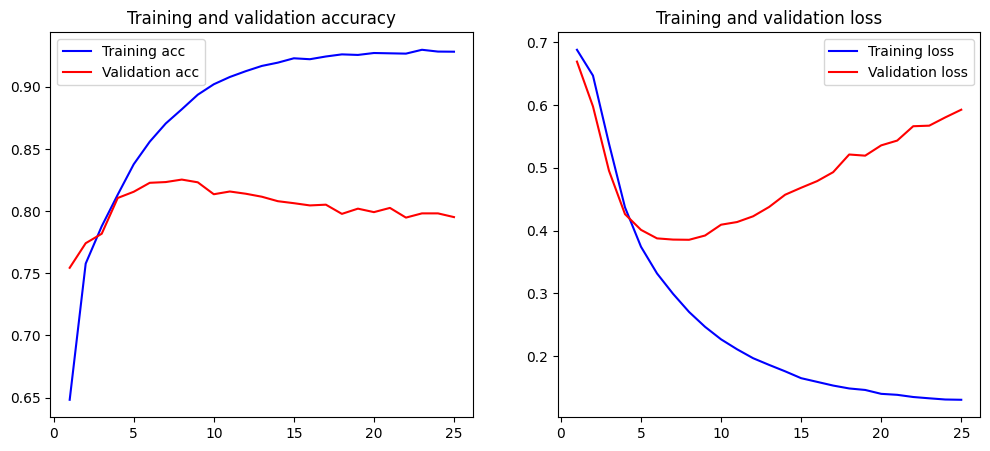

In [ ]:
dense_model = tf.keras.models.load_model('dense_best')
print_metrics(f'Best dense model LR={LEARNING_RATE}',dense_model,X_train, y_train,X_validation, y_validation)

In [ ]:
'''
text = row['Package_main'] + ' ' + row['Category'] + ' ' + row['App'] + ' ' + row['Description']
Best dense model LR=0.0001
Training Accuracy: 0.9057
Validation Accuracy:  0.8242
f1_score on validation 0.8647067877481915
''';

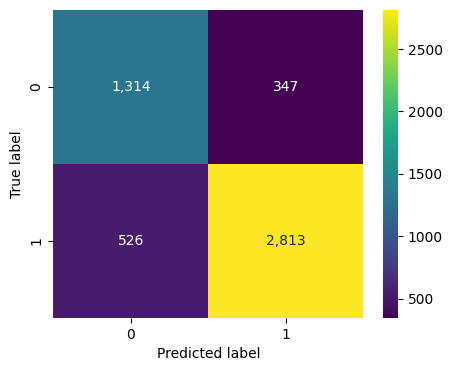

In [ ]:
print_cm(dense_model,X_validation,y_validation)

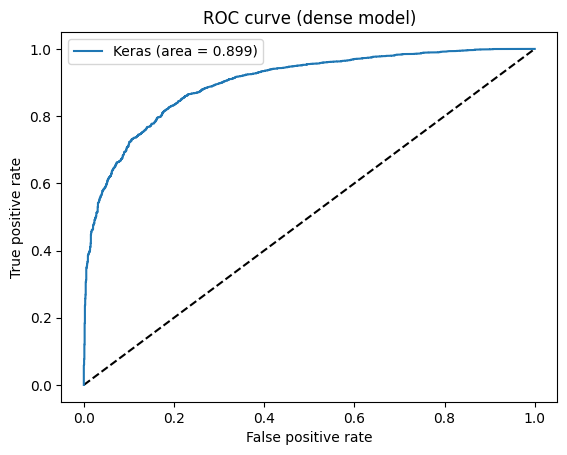

In [ ]:
show_roc_curve(dense_model,X_validation,y_validation,'dense model')
# area 0.900

In [ ]:
# Build a LSTM Model

# model = keras.Sequential()
# model.add(keras.layers.Embedding(vocab_size, EMBEDDING_SIZE))
# model.add(keras.layers.LSTM(units=128,return_sequences = False))
# #model.add(keras.layers.LSTM(units=64,return_sequences = True))
# #model.add(keras.layers.LSTM(units=32,return_sequences = False))

# # Add dropout to combat overfitting.
# model.add(keras.layers.Dropout(0.2))
# model.add(keras.layers.Dense(16, activation='relu'))
# model.add(keras.layers.Dense(1, activation='sigmoid'))


# model = keras.Sequential()
# model.add(keras.layers.Embedding(vocab_size, EMBEDDING_SIZE))
# model.add(keras.layers.Bidirectional(keras.layers.LSTM(32, return_sequences = False)))
# #model.add(keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences = False)))
# model.add(keras.layers.Dropout(0.1))
# model.add(keras.layers.Dense(20, activation="relu"))
# #model.add(keras.layers.Dense(32, activation="relu"))
# model.add(keras.layers.Dropout(0.05))
# #model.add(keras.layers.Dropout(0.1))
# #model.add(keras.layers.Dense(16, activation='relu'))
# model.add(keras.layers.Dense(1, activation="sigmoid"))
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.build()
# model.summary()


model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, EMBEDDING_SIZE))
model.add(keras.layers.Bidirectional(keras.layers.LSTM(32, return_sequences = False)))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.Dense(20, activation="relu"))
model.add(keras.layers.Dropout(0.05))
model.add(keras.layers.Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build()
model.summary()


model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 200)         6000200   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               59648     
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 20)                1300      
                                                                 
 dropout_2 (Dropout)         (None, 20)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 21        
                                                      

In [ ]:
'''
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 embedding_5 (Embedding)     (None, None, 200)         6000200   
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               59648     
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 20)                1300      
                                                                 
 dropout_7 (Dropout)         (None, 20)                0         
                                                                 
 dense_15 (Dense)            (None, 1)                 21        
                                                                 
=================================================================
Total params: 6,061,169
Trainable params: 6,061,169
Non-trainable params: 0
_________________________________________________________________
''';

In [ ]:
model.get_compile_config()

{'optimizer': 'adam',
 'loss': 'binary_crossentropy',
 'metrics': ['accuracy'],
 'loss_weights': None,
 'weighted_metrics': None,
 'run_eagerly': None,
 'steps_per_execution': None,
 'jit_compile': None}

In [ ]:
BATCH_SIZE = 64
EPOCHS = 5 # number of epochs

mcp_save = ModelCheckpoint(
    'lstm_best', save_best_only=True, monitor='val_accuracy', mode='max',
     #verbose=1
    )

history = model.fit(X_train, y_train,
                    epochs=EPOCHS,
                    verbose=True,
                    validation_data=(X_validation, y_validation),
                    batch_size=BATCH_SIZE,
                    callbacks=[mcp_save],
                    #class_weight=class_weights
                    )

Epoch 1/5
313/313 [==============================] - ETA: 0s - loss: 0.4834 - accuracy: 0.7615

313/313 [==============================] - 82s 242ms/step - loss: 0.4834 - accuracy: 0.7615 - val_loss: 0.4252 - val_accuracy: 0.8032
Epoch 2/5
313/313 [==============================] - ETA: 0s - loss: 0.3355 - accuracy: 0.8523

313/313 [==============================] - 58s 184ms/step - loss: 0.3355 - accuracy: 0.8523 - val_loss: 0.4213 - val_accuracy: 0.8056
Epoch 3/5
313/313 [==============================] - ETA: 0s - loss: 0.2618 - accuracy: 0.8862

313/313 [==============================] - 66s 210ms/step - loss: 0.2618 - accuracy: 0.8862 - val_loss: 0.4396 - val_accuracy: 0.8070
Epoch 4/5
313/313 [==============================] - 25s 81ms/step - loss: 0.2164 - accuracy: 0.9019 - val_loss: 0.5076 - val_accuracy: 0.8026
Epoch 5/5
313/313 [==============================] - 21s 67ms/step - loss: 0.1865 - accuracy: 0.9098 - val_loss: 0.5390 - val_accuracy: 0.7958


In [ ]:
'''
Epoch 1/5
313/313 [==============================] - ETA: 0s - loss: 0.4808 - accuracy: 0.7620WARNING:absl:Found untraced functions such as lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses, lstm_cell_2_layer_call_fn, lstm_cell_2_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.
313/313 [==============================] - 90s 259ms/step - loss: 0.4808 - accuracy: 0.7620 - val_loss: 0.4261 - val_accuracy: 0.8048
Epoch 2/5
313/313 [==============================] - ETA: 0s - loss: 0.3287 - accuracy: 0.8559WARNING:absl:Found untraced functions such as lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses, lstm_cell_2_layer_call_fn, lstm_cell_2_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.
313/313 [==============================] - 63s 200ms/step - loss: 0.3287 - accuracy: 0.8559 - val_loss: 0.4260 - val_accuracy: 0.8146
Epoch 3/5
313/313 [==============================] - 35s 112ms/step - loss: 0.2555 - accuracy: 0.8901 - val_loss: 0.4695 - val_accuracy: 0.8034
Epoch 4/5
313/313 [==============================] - 26s 82ms/step - loss: 0.2075 - accuracy: 0.9075 - val_loss: 0.5101 - val_accuracy: 0.7972
Epoch 5/5
313/313 [==============================] - 23s 73ms/step - loss: 0.1795 - accuracy: 0.9140 - val_loss: 0.6807 - val_accuracy: 0.7914
''';

Best LSTM model
Training Accuracy: 0.9147
Validation Accuracy:  0.8070
f1_score on validation 0.8618468146027202



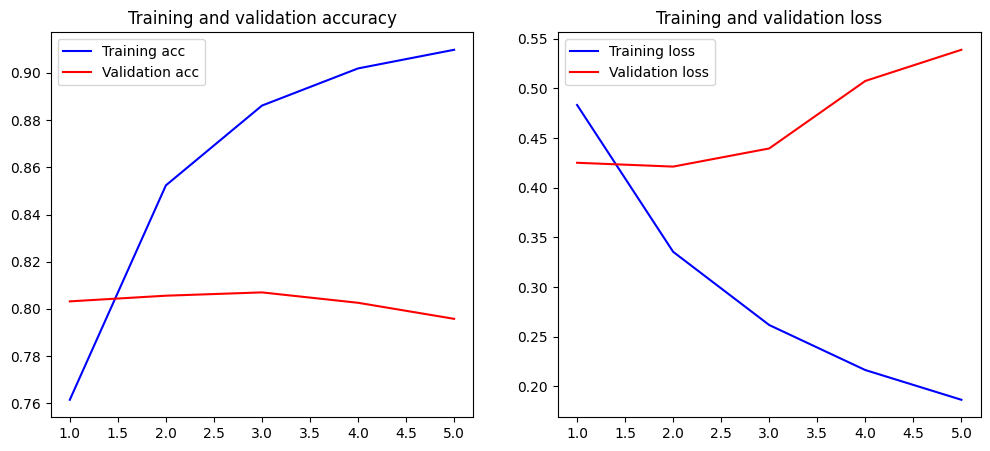

In [ ]:
lstm_model = tf.keras.models.load_model('lstm_best')
print_metrics('Best LSTM model',lstm_model,X_train, y_train,X_validation, y_validation)

In [ ]:
'''
Best LSTM model
Training Accuracy: 0.9147
Validation Accuracy:  0.8070
f1_score on validation 0.8618468146027202

'''

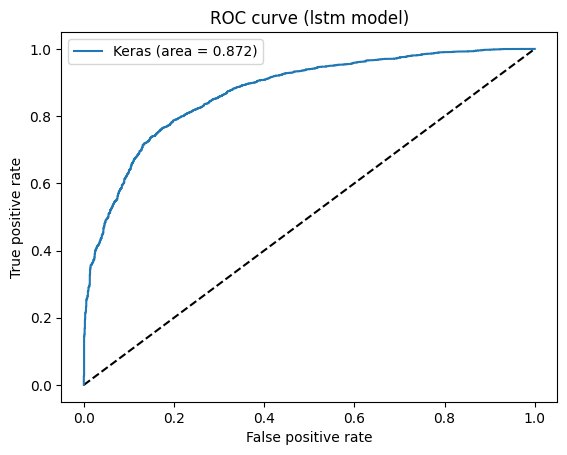

In [ ]:
show_roc_curve(lstm_model,X_validation,y_validation,'lstm model')
# Area: 0.872

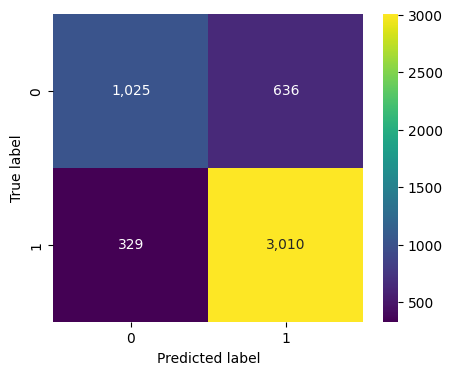

In [ ]:
print_cm(lstm_model,X_validation,y_validation)

Ensemble model: f1_score on validation 0.8737950467151119


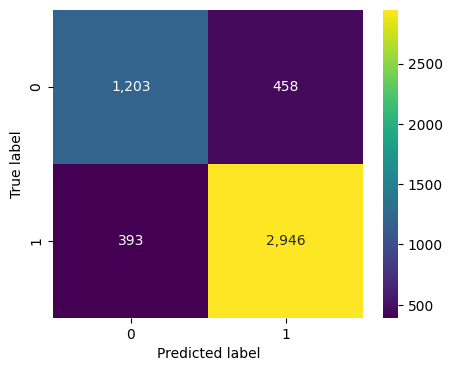

In [ ]:
# Ensemble. Since one models weakness is FN and the others FP

dense_ypred = dense_model.predict(X_validation, verbose=False)
lstm_ypred  = lstm_model.predict(X_validation, verbose=False)
ypred_proba = (dense_ypred+lstm_ypred)/2.0 # As 1st cut - Use 50-50 ensemble
ypred = ypred_proba > 0.5

print('Ensemble model: f1_score on validation',f1_score(y_validation,ypred))

#Get the confusion matrix
cf_matrix = confusion_matrix(y_validation, ypred)
fig, ax = plt.subplots(figsize=(5,4))
sns.heatmap(
    cf_matrix,annot = True,
    fmt =',d',
    cmap='viridis',
    ax=ax)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Ensemble model: f1_score on validation 0.871044776119403

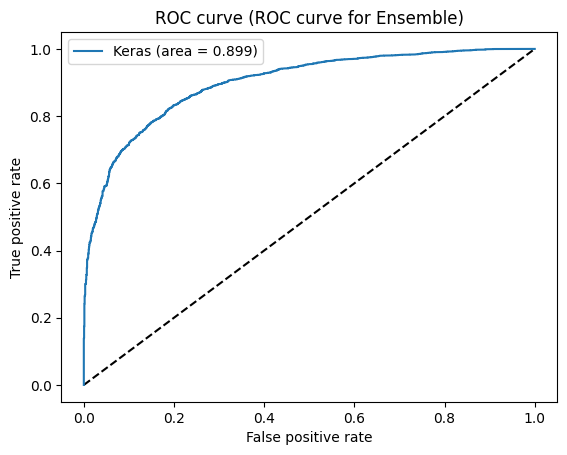

In [ ]:
title = 'ROC curve for Ensemble'
y_pred_keras = ypred_proba
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_validation, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title(f'ROC curve ({title})')
plt.legend(loc='best')
plt.show()

# area = 0.899

In [ ]:

dense_ypred = dense_model.predict(X_test, verbose=False)
lstm_ypred  = lstm_model.predict(X_test, verbose=False)
ypred_proba = (dense_ypred+lstm_ypred)/2.0 # As 1st cut - Use 50-50 ensemble
ypred = ypred_proba > 0.5

In [ ]:
ypred[:10]

array([[ True],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [False],
       [ True],
       [False]])

In [ ]:
ypred.ravel().astype(int)

array([1, 1, 1, ..., 1, 0, 1])

In [ ]:
test_df['predicted_y'] = ypred.ravel().astype(int)
test_df['predicted_y'].value_counts()

1    3386
0    1614
Name: predicted_y, dtype: int64

In [ ]:
test_df.head()

,App,Package,Category,Description,Rating,Number of ratings,Price,Related apps,Dangerous permissions count,Safe permissions count,...,Your personal information : read sensitive log data (D),Your personal information : read user defined dictionary (D),Your personal information : retrieve system internal state (S),Your personal information : set alarm in alarm clock (S),Your personal information : write Browser's history and bookmarks (D),Your personal information : write contact data (D),Your personal information : write to user defined dictionary (S),predicted_y,Package_main,text
0,ChromeMarks Lite,com.h.chromemarks.lite,Communication,Access your Chrome Bookmarks from your device....,4.5,1908,0.00,"{com.vbulletin.build_283, be.vbsteven.bmtodesk...",5.0,2,...,0,0,0,0,0,0,0,1,com,com communication chromemarks lite access chro...
1,Farm Tower HD,org.anddev.farmtower.eco,Brain & Puzzle,The animals of the Farm Tower need your help. ...,4.4,21076,0.00,"{goodteam.pair.free, com.candymobile.candyfarm...",4.0,2,...,0,0,0,0,0,0,0,1,org,org brain puzzle farm tower hd animal farm to...
2,T??gtavlan,se.tstorm.tagtavlan,Travel & Local,iPhone bestseller T??gtavlan now for Android!<...,3.0,41,1.06,"{se.fmckl.trafcam, se.locutus.sl.realtid.pay, ...",3.0,2,...,0,0,0,0,0,0,0,1,se,se travel local tgtavlan iphone bestseller tg...
3,Fair To Midland,com.novus.ftm,Entertainment,Fair to Midland are a unique alternative prog-...,5.0,7,0.00,"{com.appmakr.app93924, com.klutch22.ricekiller...",3.0,1,...,0,0,0,0,0,0,0,1,com,com entertainment fair midland fair midland un...
4,SpanishDict,com.spanishdict,Books & Reference,"A super handy Spanish dictionary, phrasebook, ...",3.4,312,0.00,"{com.advanced.android.verbs, panidiom.proconju...",1.0,0,...,0,0,0,0,0,0,0,0,com,com book reference spanishdict super handy sp...


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 186 entries, App to text
dtypes: float64(3), int64(176), object(7)
memory usage: 7.1+ MB


In [ ]:
import pandas as pd
ExcelTestData = pd.read_csv('/content/Android_test.csv',encoding="ISO-8859-1")
DatalistSVC = test_df['predicted_y']
ExcelTestData["predicted_y2"] = DatalistSVC
ExcelTestData.to_csv('/content/Android_test1.csv',index=False)